## データの取り込み

In [292]:
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns
import pandas as pd
import numpy as np
sns.set(font="IPAexGothic", style="white")
pd.set_option('display.max_columns', 30)
plt.rcParams["figure.figsize"] = [10, 5]

In [293]:
#データの取り込み
df_train_master = pd.read_csv("stock_price_predict_train.csv", parse_dates=True, index_col="date") #dateをあらかじめdatetime型にしてindexにしておく
df_submit_master = pd.read_csv("stock_price_predict_test.csv")
display(df_train_master)
display(df_submit_master)

#2010年3月~2020年1月までの約10年分の株価データであることがわかる

,close,volume,open,high,low
date,,,,,
2010-03-01,8.957,41193612,8.818,8.979,8.805
2010-03-02,8.951,42445884,8.997,9.036,8.903
2010-03-03,8.971,27853946,8.955,8.994,8.912
2010-03-04,9.030,26877572,8.969,9.039,8.941
2010-03-05,9.384,67394228,9.212,9.416,9.198
...,...,...,...,...,...
2020-01-27,92.685,12145503,93.018,93.531,91.464
2020-01-28,95.307,12167547,93.780,95.520,93.657
2020-01-29,97.302,16244979,97.335,98.355,96.414


,date
0,2020-02-03
1,2020-02-04
2,2020-02-05
3,2020-02-06
4,2020-02-07
5,2020-02-10
6,2020-02-11
7,2020-02-12
8,2020-02-13
9,2020-02-14


In [294]:
#trainデータのサマリ
display(df_train_master.info())
display(df_train_master.describe())

#データの行数は2499。LSTMを行うには少し足りない可能性もあるが、試す価値はあるデータ量。(本来、万単位のデータ数は欲しい)
#各変数におかしなデータはない。

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2499 entries, 2010-03-01 to 2020-01-31
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   close   2499 non-null   float64
 1   volume  2499 non-null   int64  
 2   open    2499 non-null   float64
 3   high    2499 non-null   float64
 4   low     2499 non-null   float64
dtypes: float64(4), int64(1)
memory usage: 117.1 KB


None

,close,volume,open,high,low
count,2499.000000,2.499000e+03,2499.000000,2499.000000,2499.000000
mean,33.982657,2.184891e+07,33.972422,34.274918,33.666878
std,17.518068,1.702255e+07,17.488229,17.644860,17.362269
min,8.951000,3.408615e+06,8.818000,8.979000,8.539000
25%,19.968000,9.250270e+06,19.933000,20.146500,19.798500
50%,30.225000,1.594278e+07,30.165000,30.450000,29.943000
75%,46.092000,2.976444e+07,46.146000,46.339500,45.762000
max,97.302000,1.387327e+08,97.335000,98.355000,96.414000


## EDA

<Axes: xlabel='date', ylabel='low'>

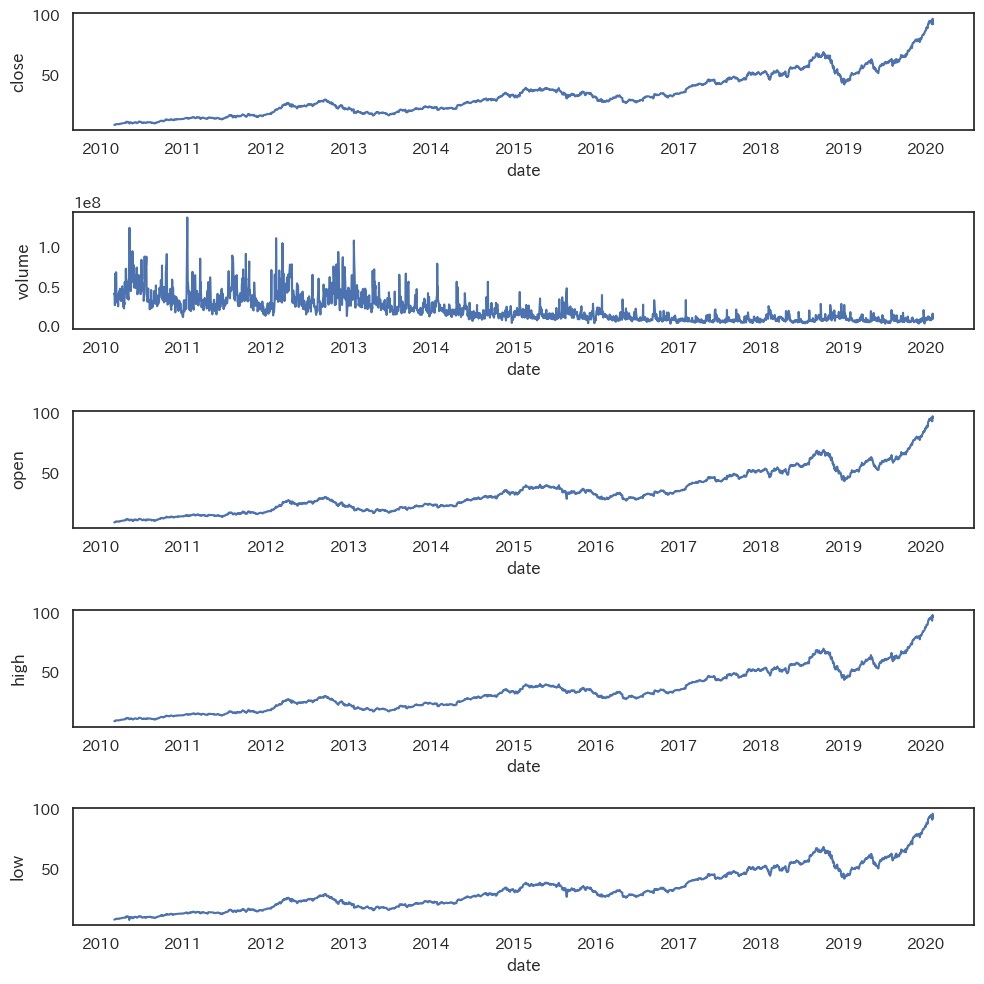

In [295]:
#推移の確認
fig, axes = plt.subplots(5, 1, tight_layout=True, figsize=(10, 10))
sns.lineplot(x="date", y="close", data=df_train_master, ax=axes[0])
sns.lineplot(x="date", y="volume", data=df_train_master, ax=axes[1])
sns.lineplot(x="date", y="open", data=df_train_master, ax=axes[2])
sns.lineplot(x="date", y="high", data=df_train_master, ax=axes[3])
sns.lineplot(x="date", y="low", data=df_train_master, ax=axes[4])

#株価は全体的に上がり基調、volumeはやや下がり基調かつ分散が小さくなっている

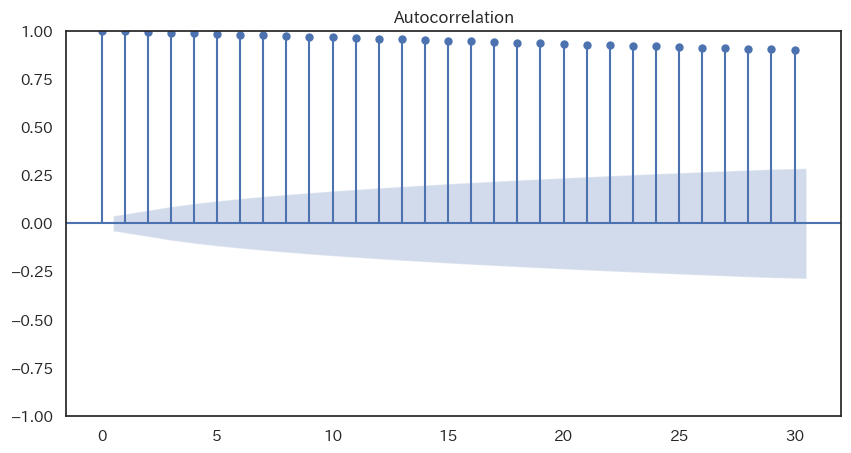

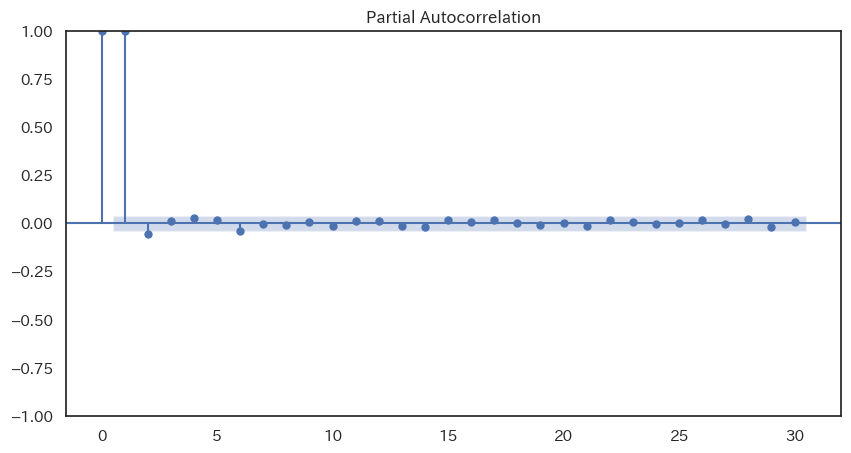

In [296]:
#コレログラム(close)
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

acf = plot_acf(df_train_master["close"], lags=30)
pacf = plot_pacf(df_train_master["close"], lags=30)

#1日前との自己相関が一番強く、2日前も負の自己相関がわずかにみられる

close以外の変数が未来のcloseの予測に役立つか、VARとグレンジャー因果を使って検証していく

In [297]:
#ADF検定(VARのための前処理)
from statsmodels.tsa.stattools import adfuller

df_eda = df_train_master.copy()
df_eda["close_lag1"] = df_eda["close"] - df_eda["close"].shift(1)
df_eda["volume_lag1"] = df_eda["volume"] - df_eda["volume"].shift(1)
df_eda["open_lag1"] = df_eda["open"] - df_eda["open"].shift(1)
df_eda["high_lag1"] = df_eda["high"] - df_eda["high"].shift(1)
df_eda["low_lag1"] = df_eda["low"] - df_eda["low"].shift(1)

for i in range(len(df_eda.columns)):
    c_results = adfuller(df_eda.iloc[:, i].dropna(), regression="c")
    print(df_eda.columns[i], c_results[1])

#各変数のlagをとることで定常性を確保(VARの条件を満たす)

close 0.9958173863281794
volume 0.050510829010127406
open 0.9983815026470219
high 0.9990861220650026
low 0.9960638148045935
close_lag1 3.5811539707473718e-12
volume_lag1 1.4484358405656383e-29
open_lag1 7.251051344278252e-17
high_lag1 2.0704604618480546e-30
low_lag1 2.1026135488050904e-16


In [298]:
#VAR
from statsmodels.tsa.vector_ar.var_model import VAR
df = df_eda[["close_lag1", "volume_lag1", "open_lag1", "high_lag1", "low_lag1"]].dropna()
maxlags = 6
var_model = VAR(df)
lag = var_model.select_order(maxlags).selected_orders
print(lag["aic"])
results = var_model.fit(lag["aic"])
print(results.summary())

#ほとんどp値が0.05を上回っており、closeの予測には役立たない可能性が高い。
#唯一2日前のopenが優位な関係を示しているが、たまたまの可能性が高そう

6
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 05, Nov, 2023
Time:                     22:03:06
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                    22.3458
Nobs:                     2492.00    HQIC:                   22.1152
Log likelihood:          -44916.7    FPE:                3.52699e+09
AIC:                      21.9837    Det(Omega_mle):     3.31557e+09
--------------------------------------------------------------------
Results for equation close_lag1
                    coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------
const                  0.030665         0.012046            2.546           0.011
L1.close_lag1         -0.065570         0.055747           -1.176           0.240
L1.volume_lag1         0.000000         0.000000 

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [299]:
# グレンジャー因果
for i in [1, 2, 3, 4]:
    test_results = results.test_causality(causing=i, caused=0)
    print(df.columns[i], "->", df.columns[0], test_results.pvalue)

# 未来のcloseと有意に関連するのはopenとlow, highの3つ。ただしデータ数が多い影響で優位差が出やすいので注意。
# openは予測に役立つ可能性がありそう。highとlowはグレーゾーン。volumeは役立たない可能性が高い。

volume_lag1 -> close_lag1 0.4941603713957393
open_lag1 -> close_lag1 5.699246178406011e-05
high_lag1 -> close_lag1 0.01185662393875578
low_lag1 -> close_lag1 0.008108109072348692


## 前処理

In [300]:
from sklearn.preprocessing import StandardScaler

#バリデーションデータの作成
train = df_train_master[:"2020-01-04"]
val = df_train_master["2020-01-05":]
#標準化
ss = StandardScaler()
train = ss.fit_transform(train)
val = ss.transform(val)
y_val = val[:, 0]
display(train)
display(y_val)

array([[-1.46475192,  1.12923057, -1.47488724, -1.47007124, -1.46815031],
       [-1.46510967,  1.20266119, -1.46419705, -1.4666969 , -1.4622553 ],
       [-1.46391717,  0.34702037, -1.46670536, -1.46918326, -1.46171392],
       ...,
       [ 3.25387383, -0.84213642,  3.19302075,  3.21404254,  3.22686691],
       [ 3.37372065, -0.68972071,  3.30607393,  3.33693948,  3.3291875 ],
       [ 3.3214889 , -0.64183664,  3.32237796,  3.33658429,  3.35282771]])

array([3.36388248, 3.33866098, 3.42452139, 3.53971744, 3.55223875,
       3.67083344, 3.59427458, 3.57030521, 3.6400668 , 3.70249447,
       3.66385728, 3.68407026, 3.71143826, 3.69498168, 3.52755388,
       3.68389138, 3.80284382, 3.79443666, 3.53757093])

In [301]:
# x_train → 直近60日分の株価データ
# y_train → 19日先までのcloseデータ
x_train = []
y_train = []

for i in range(60, len(train)-19+1):
    x_train.append(train[i-60:i, :])
    y_train.append(train[i:i+19, 0])
    if i == 60:
        print(x_train)
        print(y_train)

x_train, y_train = np.array(x_train), np.array(y_train)
print(x_train.shape)
print(y_train.shape)

[array([[-1.46475192,  1.12923057, -1.47488724, -1.47007124, -1.46815031],
       [-1.46510967,  1.20266119, -1.46419705, -1.4666969 , -1.4622553 ],
       [-1.46391717,  0.34702037, -1.46670536, -1.46918326, -1.46171392],
       [-1.46039928,  0.28976784, -1.46586926, -1.46651931, -1.45996948],
       [-1.43929193,  2.66558005, -1.45135689, -1.44420132, -1.44451011],
       [-1.4389938 ,  0.60174951, -1.43839728, -1.44325413, -1.43512621],
       [-1.42891713,  2.75812317, -1.44275696, -1.43076316, -1.43608866],
       [-1.42426635,  1.3332151 , -1.42860292, -1.42957919, -1.42237373],
       [-1.42259685,  0.49413041, -1.42842375, -1.42951999, -1.42207296],
       [-1.41979446,  0.54044568, -1.41958494, -1.42383689, -1.41581703],
       [-1.42683024,  0.87755775, -1.42466128, -1.42951999, -1.43001319],
       [-1.42527998,  0.67660363, -1.42770709, -1.43082236, -1.42417833],
       [-1.42611474,  0.69277684, -1.42585572, -1.42709283, -1.42219327],
       [-1.42474336,  0.21173543, -1.

## 予測と評価

In [302]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

# モデル作成
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], x_train.shape[2])))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(128))
model.add(Dense(19))

# 学習方法指定
model.compile(optimizer='adam', loss='mean_squared_error')

# 学習開始
model.fit(x_train, y_train, batch_size=128, epochs=5)

Epoch 1/5
19/19 [==============================] - 3s 79ms/step - loss: 0.3094
Epoch 2/5
19/19 [==============================] - 2s 82ms/step - loss: 0.0336
Epoch 3/5
19/19 [==============================] - 2s 79ms/step - loss: 0.0187
Epoch 4/5
19/19 [==============================] - 2s 80ms/step - loss: 0.0164
Epoch 5/5
19/19 [==============================] - 2s 81ms/step - loss: 0.0150


In [303]:
# trainデータの最後60日間のデータを使ってその後19日の予測をする
x_val = train[len(train)-60:, :]
x_val = np.array(x_val)
x_val = np.reshape(x_val, (1, 60, 5))

# 予測    
predictions = model.predict(x_val)
print(predictions)

#RMSE計算
rmse = np.sqrt(np.mean(((predictions - y_val) ** 2)))
print("LSTM:", rmse)

1/1 [==============================] - 0s 281ms/step
[[3.2379937 3.2374141 3.1649654 3.241917  3.3715823 3.3142064 3.227219
  3.2158067 3.0970194 3.3731396 3.2148302 3.2940073 3.2653048 3.291495
  3.2637634 3.2882295 3.359267  3.442488  3.3462098]]
LSTM: 0.3482844491263942


In [304]:
#ベースラインRMSE計算
baseline = train[len(train)-19:, 0]
rmse = np.sqrt(np.mean(((baseline - y_val) ** 2)))
print("baseline:", rmse)

#ベースラインモデルより精度が良好であることを確認

baseline: 0.5780038817414731


In [305]:
# サブミットデータの作成

# 直近60日のデータを取得
submit_train = df_train_master.copy()
submit_train = ss.transform(submit_train)
submit_train = submit_train[len(submit_train)-60:, :]
submit_train = np.reshape(submit_train, (1, 60, 5))

# 2月分のcloseを予測
submit_pred = model.predict(submit_train)

# 標準化した数値を元の状態に戻す
submit_pred_std = []
for i in range(0, 19):
    submit_pred_std.append([submit_pred[0][i], 0, 0, 0, 0])
submit_pred = ss.inverse_transform(submit_pred_std)
submit_pred = submit_pred[:, 0]

#予測値をサブミット用データフレームに結合
df_submit = df_submit_master.copy()
df_submit["y"] = submit_pred
df_submit.to_csv("stock_price_predict_submit.csv", index=False)
df_submit

#　最終スコア6.16

1/1 [==============================] - 0s 12ms/step


,date,y
0,2020-02-03,92.047939
1,2020-02-04,91.363884
2,2020-02-05,90.613296
3,2020-02-06,92.823595
4,2020-02-07,94.986518
5,2020-02-10,93.495626
6,2020-02-11,91.752301
7,2020-02-12,91.724163
8,2020-02-13,89.087388
9,2020-02-14,94.866095
